# Exploring Practical Recommendation Systems In Neo4j
### __An Example With Collaborative Leveraging Graph Data Science and Machgine Learning__

In this notebook we explore how to get started with practical & scalable recommendation in graph. We will walk through a fundamental example with recipe recommendation on dataset containing 231k recipes and around 226K users. We will leverage Neo4j and the Graph Data Science (GDS) library to quickly predict similar recipes based on user preferences and enable sub-second, rank-ordered, recommendation queries personalized to each user.

This notebook is structured as follows: 

1. Setup some configurations and helper functions to allow us to work with the graph. 
2. Go over the source dataset and graph we will be using along with how to query basic profiling statistics to help us understand the graph and better prepare for analysis. 
3. Briefly introduce a technique called Collaborative filtering (CF) which will be our mechanism for recommendation in this notebook
4. Explore Applying the Cypher query language for basic CF
5. Scaling CF with the Graph Data Science (GDS) Library, leveraging Node embeddings and an ML technique called K-Nearest Neighbor (KNN).

In [1]:
from graphdatascience import GraphDataScience
import pandas as pd
import configparser
import os
import numpy as np
import importlib
from tqdm.notebook import tqdm

# Set pandas options
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 12)

In [2]:
# Import custom modules
from src import queries, utils

# Reload modules
importlib.reload(queries)
importlib.reload(utils)

print('Modules reloaded')

Modules reloaded


### <a id="N4jSettings">Neo4j Settings</a>

The `NEO4J_PROPERTIES_FILE` is an ini configuration file for Neo4j properties so this notebook can connect to
your Neo4j instance and load data. The ini file should be formatted as follows
```
[NEO4J]
PASSWORD=<password>
USERNAME=<database name, is 'neo4j' by default>
HOST=<host uri>

```

Set `NEO4J_PROPERTIES_FILE` to None or any non-existent location to use the below defaults
```
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'
```

In [3]:
NEO4J_PROPERTIES_FILE = None #'/path/to/your/file.ini'
# Replace with your Neo4j import directory
NEO4J_IMPORT_DIR = '/home/luigi/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-c5c50094-d809-4eeb-84f4-745becc1cd52/import'

In [4]:
# Using an ini file for credentials, otherwise providing defaults
HOST = 'bolt://localhost:7687'
DATABASE = 'neo4j'
PASSWORD = 'LU?vVtYf8])9;^z'

if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_PROPERTIES_FILE)
    HOST = config['NEO4J']['HOST']
    USERNAME = config['NEO4J']['USERNAME']
    PASSWORD = config['NEO4J']['PASSWORD']
    print('Using custom database properties')
else:
    print('Could not find database properties file, using defaults')

Could not find database properties file, using defaults


In [5]:
# Create a connection to the database
gds = GraphDataScience(HOST, auth=(DATABASE, PASSWORD))

```
//visualize schema in Neo4j Browser
neo4j$ CALL db.schema.visualization();
```
![image](./image/nodes.png)

We see that recipes are modeled as nodes and can can be "submitted" or "reviewed" by users which are also modeled as nodes. 
Additionally, News also have ingredients and it's relation with recipe. These will be useful for extended analysis, but we will not be using them in this example. Our primary interest here is to get started with users and their reviews to derive recommendations.

### <a id="DataProfiling">Graph Data Profiling</a>

Before diving right into into analysis, it is helpful to inspect some high level statistics of graph to get a better sense of size and connectivity.

#### Aggregate Counts
Let's start with high node and relationships counts. These functions assume [APOC](https://neo4j.com/developer/neo4j-apoc/) is installed on your Neo4j DB.

In [6]:
# Total node count
queries.get_node_counts(gds)


Query executed in 0.01 seconds


,label,nodeCount
0,User,1382
1,Recipe,231637


In [7]:
# total relationship counts
queries.get_relationship_counts(gds)


Query executed in 0.01 seconds


,type,relationshipCount
0,SUBMITTED,129211
1,REVIEWED,20000


As far as search recommendation is concerns this is a relatively modestly sized graph, with only around 226K users, 231k news articles, and around 500k total creations/reviews.

#### <a id="RewDist">Reviews Distributions</a>



Next, we can look at the distribution of events per user. It is helpful to check this distribution to make sure that:
1. The graph is reasonably well connected as the quality of our upcoming recommendation technique will depend on a reasonably well connected graph.
2. We do not have any large [supernodes](https://medium.com/neo4j/graph-modeling-all-about-super-nodes-d6ad7e11015b), i.e. nodes with very high numbers of relationships. What qualifies as a supernode varies greatly by use case. For this, I would be concerned about users with tens of thousands of clicks.

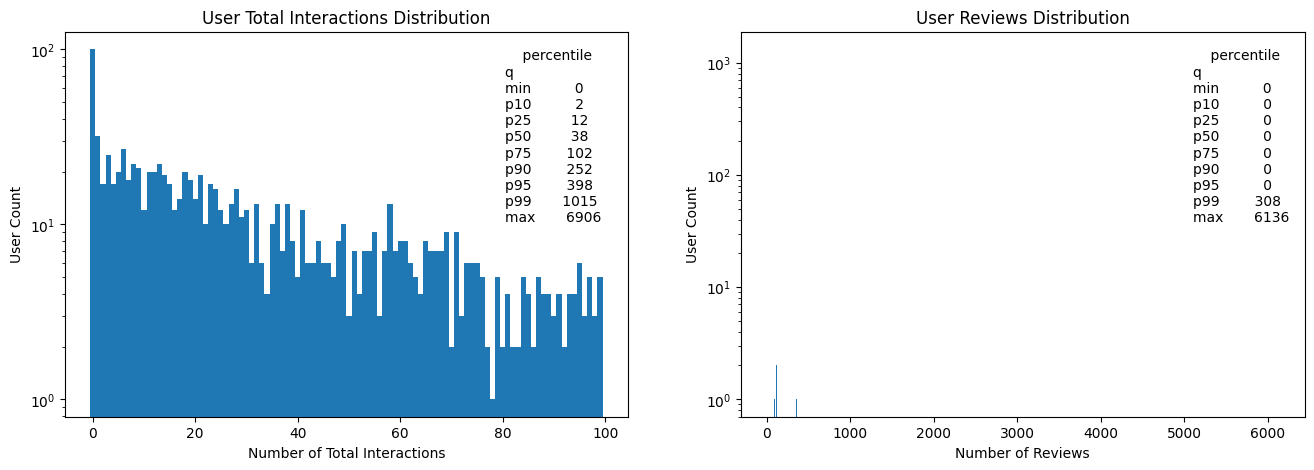

In [8]:
# Define the top number of rewires
n_rew = 100

# Plot interactions distribution
utils.plot_interactions_distribution(gds, n_rew)

The above shows the distributions for total interactions (`REVIEWED` and `SUBMITTED`) as well as reviews (just `REVIEWED`) by user. We see that the distributions have heavy left tails, showing that activity is not uniformly distributed among users, but rather there is relatively small fraction of users that account for a large number of interactions. This is somewhat expected. 

We can do a similar breakdown for Recipe below.

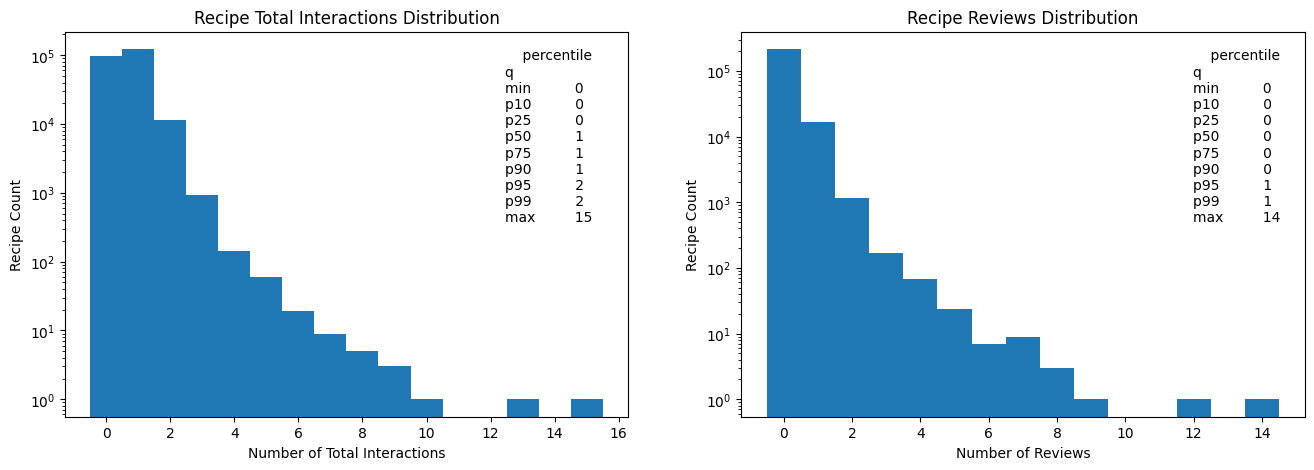

In [9]:
# Plot interactions distribution
utils.plot_recipe_interactions_distribution(gds, n_rew)

## <a id="CF">Collaborative Filtering (CF)</a>


There are many different types of recommendations systems. In this example we will apply a technique called Collaborative Filtering (CF), which is the practice of automatically predicting a user's preferences based on the actions of similar users.

### <a id="UservsItemCF">User vs Item Based CF</a>
Roughly speaking there are two main classes of collaborative filtering
1. User-based, which is focuses on directly calculating similarity between users based on their interaction with items
2. Item-based, which measures the similarity between pairs of items based on correlated user activity, such as the same users liking, viewing, rating, or otherwise similarly interacting with items

Our approach today will focus on the later, item-based CF. Item-based CF will be more manageable and scalable then user-based CF for many problem domains. There are a couple reasons for this. First, because there are way fewer items then users in most applied cases so there are less entities to compare. Second, and perhaps more importantly, User preferences can also be dynamic and change overtime. For example, in a Movie example, a user could be mostly interested in Sci Fi movies but go through a brief stint in Westerns, and making recommendations for Westerns to other Sci Fi fans who historically viewed the same things may not be the best thing. Often the best indicator of a user's current interest is their most recent activity, and item based filtering gives you better flexibility to find similarities based off the most recent item(s) submitted, rated, etc.

### <a id="BasicQueries">Basic Cypher Queries for CF</a>
From here we could try just using Cypher to accomplish basic Collaborative Filtering. For example, take the below user and the news they clicked. You can see a mixed interest between autos, finance, US news, and a couple other categories.

In [10]:
# Select a random user that has at least n_rew reviews
random_user_query = queries.get_random_user(gds, n_rew)

# Get the user ID
USER_ID = str(random_user_query['randomUserID'][0])
print(f"Selected user {USER_ID} with", random_user_query['reviewCount'][0], 'reviews')


Query executed in 0.02 seconds
Selected user 27395 with 148 reviews


In [11]:
# Print some of the user interactions
user_interactions = queries.get_user_interactions(gds, USER_ID)
interacted_recipes = list(set(user_interactions['recipeID']))

# Show result
user_interactions.head()


Query executed in 0.02 seconds


,recipeID,name,nutrition,n_ingredients,interactionDate,interactionType
0,36561,stir fried shrimp in garlic sauce,"[216.6, 14.0, 1.0, 67.0, 46.0, 6.0, 2.0]",15,2004-01-05,REVIEWED
1,74251,black pepper butter cookies,"[73.3, 6.0, 16.0, 1.0, 1.0, 12.0, 2.0]",8,2004-01-05,REVIEWED
2,79745,summertime italian green beans,"[383.4, 51.0, 49.0, 97.0, 4.0, 26.0, 7.0]",3,2003-12-30,REVIEWED
3,30082,cheesecake cups,"[171.5, 17.0, 41.0, 4.0, 5.0, 29.0, 4.0]",5,2003-12-15,REVIEWED
4,72990,chinese roast chicken,"[616.3, 64.0, 38.0, 90.0, 93.0, 54.0, 4.0]",9,2003-12-14,REVIEWED


Assuming we can measure the similarity of user interests via commonly reviewed recipes, we can do a three hop query to find potential recommendations for user `27711` based on the activity of users that reviewed the same recipe as `27711` (or even reviewed their recipe high).

With the below query we can get an aggregate count of the nodes we would need to traverse over to get the recommendations.

In [12]:
# Get the number of possible suggestions
queries.get_hops_count(gds, USER_ID)


Query executed in 0.06 seconds


,userId,interactedRecipesCount,likeUsersCount,potentialRecommendationsCount
0,27395,108,81,37491


While the above can work well in some cases, and while it can certainly be a massive improvement from joining SQL tables or cross-walking over document stores, notice that we get a lot of potential recommendations back (about 13K). And this is just a sample of the the total dataset.

For production use cases where recommendations will need to be queried frequently, this method will have trouble scaling as the number of users, amount of content, and/or observed engagement grows. We need some other strategy to help narrow down the results. There are a few different ways we can accomplish this, but one robust and scalable way to do so is with the [Neo4j Graph Data Science (GDS) Library](https://neo4j.com/docs/graph-data-science/current/).

In [13]:
# Load generated test data
test_reviewed_df = pd.read_csv(os.path.join(NEO4J_IMPORT_DIR, 'test_reviewed.csv'))

#### <a id="favIngrRec">Recommendation based on favorite ingredients</a>
First let's make a list of excluded ingredients. Those ingredients won't be considered as they're common ingredients in recipies.

In [14]:
# Define a list of (common) ingredients to exclude
excluded_ingr = [
    'salt', 'butter', 'sugar', 'onion', 'water', 'eggs', 'olive oil', 'flour',
    'milk', 'garlic cloves', 'pepper', 'brown sugar', 'garlic', 'all-purpose flour',
    'baking powder', 'egg', 'salt and pepper', 'baking soda',
]

In [15]:
# Compute top 5 user ingredients
favIngr = queries.get_user_favourite_ingredients(
    gds, 
    USER_ID, 
    excluded_ingr
)

# Extract the favorite ingredients
favorite_ingredients = list(favIngr['favoriteIngredient'])

# Show result
favIngr[['favoriteIngredient', 'favCount']]


Query executed in 0.02 seconds


,favoriteIngredient,favCount
0,garlic powder,59
1,black pepper,53
2,soy sauce,32
3,celery,29
4,cream cheese,25
...,...,...
17,cinnamon,14
18,carrots,14
19,fresh mushrooms,13
20,salt and black pepper,13


In [16]:
# Suggest recipes based on user's favorites ingredients
favIngrRec = queries.get_recipe_w_ingreds(
    gds, 
    interacted_recipes, 
    favorite_ingredients, 
    excluded_ingr
)

# Show result
favIngrRec.head()


Query executed in 6.01 seconds


,recipeID,recipeName,recipeIngredients,matchCount,totalIngredients,relevanceScore
0,470564,tomato garlic dressing,"[mayonnaise, lemon juice, garlic powder, tomatoes]",4,4,1.609438
1,96923,quick ham stir fry,"[soy sauce, celery, cooked ham, black pepper, cooked rice, green pepper, onion, garlic powder, vegetable oil]",6,9,1.535057
2,290391,asparagus tomato stir fry,"[cornstarch, chicken broth, green onions, soy sauce, fresh mushrooms, asparagus spear, cooking oil, tomatoes, gingerroot]",6,9,1.535057
3,117703,ez asian chicken or turkey stir fry,"[turkey breast, sliced water chestnuts, ground ginger, chicken broth, garlic powder, oil, cornstarch, green onions, bok choy, dry sherry, fresh mushrooms, soy sauce]",7,12,1.496220
4,300239,celery parmegiana,"[tomatoes, onions, parmesan cheese, margarine, garlic powder, water, celery]",5,7,1.485315


#### <a id="NutrValRec">Recommendation based on nutritonal properties</a>
In addition to suggestin recipes based on preferred ingredients, it's also possible to identify user preferences on nutritional values and make suggestions based on this data. We will study a user favorite nutritional values based on both the recipes he has submitted and reviewed.

In [17]:
# Obtain nutritional values
nutrVal = queries.get_user_nutritional_values(
    gds, 
    USER_ID
)

# Show result
nutrVal.head()


Query executed in 0.01 seconds


,recipeID,calories,totalFat,sugar,sodium,protein,saturatedFat,carbs
0,45459,200.4,0.0,173.0,6.0,6.0,0.0,16.0
1,34519,445.4,37.0,63.0,47.0,37.0,41.0,12.0
2,54882,446.1,9.0,19.0,24.0,25.0,4.0,29.0
3,17741,277.6,17.0,27.0,45.0,45.0,20.0,8.0
4,16619,82.6,2.0,5.0,6.0,5.0,1.0,4.0


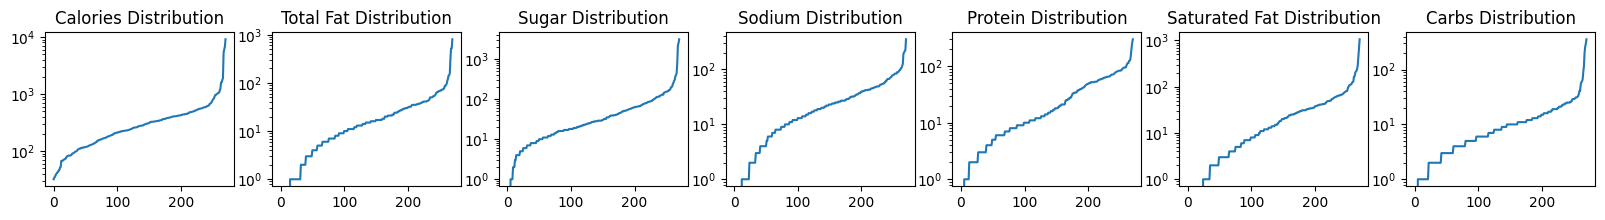

50% of calories data lies between 144.70 and 434.75
50% of total fat data lies between 6.00 and 32.00
50% of sugar data lies between 12.00 and 64.00
50% of sodium data lies between 8.00 and 40.00
50% of protein data lies between 6.00 and 50.00
50% of saturated fat data lies between 4.00 and 38.50
50% of carbs data lies between 4.00 and 15.50


In [18]:
# Plot nutritional values
utils.plot_nutritional_values(nutrVal)
# Get nutritional values ranges
calories_range, fat_range, sugar_range, sodium_range, protein_range, sat_fat_range, carbs_range = utils.get_nutritional_values(nutrVal)

In [19]:
# Suggest recipe based on nutritional values
nutrValRec = queries.get_recipe_nutritional_values(
    gds, 
    interacted_recipes, 
    calories_range, 
    fat_range, 
    sugar_range, 
    sodium_range, 
    protein_range,
    sat_fat_range,
    carbs_range
)

# Show result
nutrValRec.head()


Query executed in 0.46 seconds


,recipeID,recipeName,nutritionList
0,100026,baking powder meatballs,"[312.1, 29.0, 9.0, 39.0, 35.0, 32.0, 5.0]"
1,10003,spicy corn salad with avocado dressing,"[286.0, 21.0, 29.0, 23.0, 13.0, 17.0, 14.0]"
2,100058,daddy s chili con carne,"[308.8, 11.0, 32.0, 27.0, 41.0, 14.0, 13.0]"
3,100083,herb mustard roast potatoes,"[233.4, 12.0, 12.0, 10.0, 10.0, 5.0, 12.0]"
4,100085,sausage cheese english muffins,"[245.9, 15.0, 8.0, 20.0, 25.0, 14.0, 8.0]"


We can also combine the user preferences on ingredients with those on nutritional values to provide even more accurate recommendations. We can than sort the result based on most matching favorites ingredients and show first recipes with less preparation time.

In [20]:
# Suggest recipe based on favorite ingredients and nutritional values
fitRecFavIngr = queries.get_recipe_nutritional_ingreds(
    gds, 
    interacted_recipes, 
    favorite_ingredients, 
    calories_range, 
    fat_range, 
    sugar_range, 
    sodium_range, 
    protein_range,
    sat_fat_range,
    carbs_range,
)

# Show result
fitRecFavIngr.head()


Query executed in 3.84 seconds


,recipeID,recipeName,recipeIngredients,nutritionList,relevanceScore
0,284321,garlic chicken and corn stir fry,"[celery, soy sauce, chicken broth, vegetable oil, onion powder, black pepper, cornstarch, red bell pepper, cooked rice, garlic cloves, boneless skinless chicken thighs, frozen corn]","[318.1, 9.0, 10.0, 18.0, 39.0, 6.0, 15.0]",1.282475
1,36765,vegetable pork stir fry,"[fresh mushrooms, green pepper, reduced sodium soy sauce, garlic, carrot, cornstarch, zucchini, cooked rice, pork tenderloin, vegetable oil, chicken broth, celery ribs]","[252.5, 7.0, 13.0, 15.0, 33.0, 5.0, 11.0]",1.282475
2,337419,black bean soup from dried beans,"[onion, dried black beans, black pepper, chicken bouillon cubes, garlic powder, oil, celery, carrots, salt]","[272.3, 9.0, 17.0, 31.0, 27.0, 5.0, 13.0]",1.279214
3,251746,vermicelli olive pasta salad,"[vegetable oil, green pepper, accent seasoning, vermicelli, celery, green olives, water chestnuts, onion, lawry's seasoned salt, mayonnaise, lemon juice, parmesan cheese, black olives]","[299.3, 26.0, 12.0, 32.0, 10.0, 12.0, 10.0]",1.218026
4,150920,no cream creamy broccoli soup,"[oil, fresh broccoli, milk, minute white rice, celery, chicken broth, water, onion, parmesan cheese, carrots]","[160.7, 11.0, 11.0, 19.0, 15.0, 13.0, 5.0]",1.198948


#### <a id="TagsRec">Recommendation based on website tags</a>
Another thing we can leverage to suggest recipes to our user is Site Tags. All recipe tags are easily obtained from the following query.

In [21]:
# Get recipe taglist with count
queries.get_recipes_taglist(gds).head()


Query executed in 0.78 seconds


,tag,tagCount
0,preparation,230546
1,time-to-make,225326
2,course,218148
3,main-ingredient,170446
4,dietary,165091


Here we can see that there are very common tags that we're likely to exclude from the taglist, that way we can obtain more user-specific recommendation.

In [22]:
# Define a list of (common) tags to exclude
excluded_tags = [
    'preparation', 'time-to-make', 'course', 'main-ingredient', 'dietary', 'easy', 
    'occasion', 'cuisine', 'low-in-something', 'main-dish', 'equipment', '60-minutes-or-less',
    'number-of-servings', 'meat', '30-minutes-or-less', 'vegetables', 'taste-mood',
    '4-hours-or-less', 'north-american', '3-steps-or-less',
]

We can also just check all tags of the recipes an user has reviewed, count them, and order by count to obtain the top tags of an user.

In [23]:
# Get top user tags
userTags = queries.get_user_top_tags(gds, USER_ID, excluded_tags)

# Extract the top tags
top_tags = list(userTags['tag'])

# Show result
userTags


Query executed in 0.01 seconds


,tag,tagCount
0,oven,90
1,to-go,79
2,weeknight,68
3,healthy,65
4,stove-top,64
...,...,...
30,presentation,38
31,poultry,38
32,pasta,36
33,beginner-cook,35


In [24]:
# Suggest recipe based on user's top tags
queries.find_top_tag_matching_recipes(gds, interacted_recipes, top_tags).head()


Query executed in 12.14 seconds


,recipeID,recipeName,tagList,matchCount,totalTags,relevanceScore
0,140009,fresh fruit kebabs,"[15-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, low-protein, healthy, appetizers, desserts, fruit, easy, no-cook, beginner-cook, dinner-party, holiday-event, kid-friendly, low-fat, vegetarian, dietary, low-sodium, low-cholesterol, low-saturated-fat, low-calorie, inexpensive, healthy-2, free-of-something, low-in-something, brunch, to-go, technique]",20,33,2.137188
1,42053,zesty dijon green beans,"[weeknight, time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, low-protein, healthy, lunch, side-dishes, vegetables, american, southern-united-states, easy, beginner-cook, potluck, dinner-party, holiday-event, low-fat, picnic, romantic, stove-top, dietary, low-sodium, low-cholesterol, low-saturated-fat, low-calorie, low-carb, inexpensive, healthy-2, low-in-something, taste-mood, to-go, equipment]",21,36,2.106369
2,51262,lemon pepper mushrooms,"[30-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, low-protein, healthy, appetizers, lunch, side-dishes, eggs-dairy, vegetables, american, oven, potluck, dinner-party, finger-food, vegetarian, dietary, low-sodium, low-cholesterol, low-saturated-fat, low-calorie, low-carb, inexpensive, mushrooms, healthy-2, low-in-something, to-go, equipment, presentation]",20,34,2.091381
3,20265,fruit salad for 5 a day,"[15-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, low-protein, healthy, 5-ingredients-or-less, lunch, salads, side-dishes, fruit, easy, no-cook, beginner-cook, potluck, kid-friendly, low-fat, picnic, vegetarian, dietary, low-sodium, low-cholesterol, low-saturated-fat, low-calorie, brown-bag, inexpensive, healthy-2, low-in-something, to-go, 3-steps-or-less, technique]",20,35,2.047725
4,9990,aunt edna s dill pickles,"[15-minutes-or-less, time-to-make, course, main-ingredient, preparation, occasion, low-protein, healthy, appetizers, canning, lunch, side-dishes, vegetables, potluck, dinner-party, heirloom-historical, holiday-event, low-fat, picnic, summer, vegan, vegetarian, dietary, low-cholesterol, seasonal, low-saturated-fat, low-calorie, comfort-food, low-carb, low-in-something, taste-mood, to-go, number-of-servings, presentation, technique]",20,35,2.047725


#### <a id="AllRecs">Combine all suggestions together</a>

In [25]:
# Suggest recipe based on user's favorite ingredients, top tags
# and nutritional values
queries.find_matching_recipes_with_nutrition_and_tags(
    gds,  
    interacted_recipes, 
    favorite_ingredients, 
    top_tags, 
    calories_range, 
    fat_range, 
    sugar_range, 
    sodium_range, 
    protein_range,
    sat_fat_range,
    carbs_range,
).head()


Query executed in 8.32 seconds


,recipeID,recipeName,matchingIngreds,matchingTags,ingrRelScore,tagRelScore
0,284321,garlic chicken and corn stir fry,6,9,1.282475,1.370035
1,43346,spectacular spaghetti squash saute,5,12,1.129503,1.521155
2,36765,vegetable pork stir fry,6,10,1.282475,1.303239
3,89697,nat s rice sticks,3,14,0.677702,1.877678
4,268766,orzo garden medley,3,15,0.677702,1.803908


## Evaluation

In [26]:
# Load generated test data
test_reviewed_df = pd.read_csv(os.path.join(NEO4J_IMPORT_DIR, 'test_reviewed.csv'))
# Load train data
train_reviewed_df = pd.read_csv(os.path.join(NEO4J_IMPORT_DIR, 'reviewed.csv'))

# Show result
test_reviewed_df.head()

,user_id,recipe_id,date,rating,review
0,1533,113227,2005-04-22,5,"Stinkerbell, this recipe was great, I served it with steak and a salad.\r\n4 People ate the all. (I have to stop inviting the big eaters to dinner). Thanks so much and yes it is a keeper."
1,1533,13813,2005-05-05,5,"This is amazing, everyone enjoyed it.\r\nWe all loved the crunch.\r\nI had 2 cans of pumpkin so I was all set.\r\nThanks for such a great treat.\r\nIts a keeper."
2,1533,110139,2005-05-05,5,Oh Tish this has been helpful.\r\nI made the recipe and frozen half in 4 c. serving containers.\r\nIt was great the first night and next day..but what came out of the freezer was so good. All i added was a little water mixed with soy sauce. add to the wok and perfect.\r\nIts a keeper and Im going to make it again sunday. Thanks great recipe.
3,1533,45218,2005-05-05,5,"I had just enough raisin bran cereal to make these. They turned out lovely.\r\nI froze 12 of them and they did come out perfect.\r\nThanks so much, its a keeper."
4,1533,81473,2005-05-12,5,"Tebo, oh my this was wonderful. I served it with Bergy's Black Bean Spareribs #23717.\r\nIt was such a nice combo.\r\nThanks so much Tebo.\r\nIts a keeper."


In [27]:
# Initialize lists to store metrics for each user
precisions = []
recalls = []

# Iterate over a sample of N unique users in the test set
for user_id in tqdm(np.random.choice(test_reviewed_df['user_id'].unique(), size=50, replace=False), desc='Evaluating users'):

    # Retrieve recipies the user has interacted with (reviewed or published)
    interacted_recipes = list(set(queries.get_user_interactions(gds, str(user_id), verbose=False)['recipeID']))

    # INGREDIENTS #############################################################################################
    favIngr = queries.get_user_favourite_ingredients(
        gds, 
        str(user_id), 
        excluded_ingr,
        verbose=False
    )
    # Skip if no favorite ingredients found
    if favIngr.empty: continue
    # Calculate the threshold count for the given percentile
    # To do so, we need to remove duplicates and calculate the percentile
    threshold_count = np.percentile(list(set(favIngr['favCount'])), 50)
    # Filter the DataFrame for ingredients above the threshold
    favIngr = favIngr[favIngr['favCount'] >= threshold_count]
    # Extract favorite ingredients
    favorite_ingredients = list(favIngr['favoriteIngredient'])


    # TAGS ###################################################################################################
    userTags = queries.get_user_top_tags(
        gds, 
        str(user_id), 
        excluded_tags, 
        verbose=False
    )
    # Skip if no tags found
    if userTags.empty:
        print(f"No tags found for user {user_id}, using default tags...")
        continue

    # Calculate the threshold count for the given percentile
    # To do so, we need to remove duplicates and calculate the percentile
    threshold_count = np.percentile(list(set(userTags['tagCount'])), 50)
    # Filter the DataFrame for tags count above the threshold
    userTags = userTags[userTags['tagCount'] >= threshold_count]
    # Extract the top tags
    top_tags = list(userTags['tag'])


    # NUTRITIONAL VALUES #######################################################################################
    nutrVal = queries.get_user_nutritional_values(
        gds, 
        str(user_id), 
        verbose=False
    )
    # Skip if no nutritional values found
    if nutrVal.empty:
        print(f"No nutritional values found for user {user_id}, using default ranges...")
        continue
    # Get nutritional values ranges
    calories_range, fat_range, sugar_range, sodium_range, protein_range, sat_fat_range, carbs_range = utils.get_nutritional_values(nutrVal, verbose=False)


    # RECOMMENDATIONS ##########################################################################################
    recs_df = queries.find_matching_recipes_with_nutrition_and_tags(
        gds, 
        interacted_recipes, 
        favorite_ingredients, 
        list(userTags['tag']), 
        calories_range, 
        fat_range, 
        sugar_range, 
        sodium_range, 
        protein_range,
        sat_fat_range,
        carbs_range,
        verbose=False
    )
    # Skip if no recommendations found
    if recs_df.empty:
        print(f"No recommendations found for user {user_id}, skipping evaluation...")
        continue

    # Filter the test set for the selected user
    user_test_df = test_reviewed_df[test_reviewed_df['user_id'] == user_id].copy()
    # Convert recipe_id in user_test_df to string for consistent comparison
    user_test_df['recipe_id'] = user_test_df['recipe_id'].astype(str)

    # Convert recommended RecipeIDs to a set for faster checks
    recommended_ids = set(recs_df['recipeID'])
    # Check if each recommended recipe is in the user's test interactions
    relevant_items = user_test_df[user_test_df['recipe_id'].isin(recommended_ids)]

    # Calculate True Positives (TP): recommended & relevant
    TP = len(relevant_items)
    # False Positives (FP): recommended but not relevant
    FP = len(recommended_ids) - TP
    # False Negatives (FN): relevant but not recommended
    FN = len(user_test_df) - TP
    # Compute Precision and Recall
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0

    # Store the precision and recall for each user
    precisions.append(precision)
    recalls.append(recall)
    
# After iterating through all users, compute the mean of precision and recall
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

# Compute F1 score if needed
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
mean_f1_score = np.mean(f1_scores)

# Print the final aggregated results
print(f"Mean Precision: {mean_precision:.2f}")
print(f"Mean Recall: {mean_recall:.2f}")
print(f"Mean F1 Score: {mean_f1_score:.2f}")

Evaluating users:   0%|          | 0/50 [00:00<?, ?it/s]

No recommendations found for user 1287956, skipping evaluation...
No recommendations found for user 1020416, skipping evaluation...
No recommendations found for user 529278, skipping evaluation...
No recommendations found for user 1175362, skipping evaluation...
No recommendations found for user 104472, skipping evaluation...
Mean Precision: 0.00
Mean Recall: 0.01
Mean F1 Score: 0.00


In [33]:
user_id = str(np.random.choice(test_reviewed_df['user_id'].unique(), size=1, replace=False)[0])
print("User:", user_id)
# Compute top 5 user ingredients
favIngr = queries.get_user_favourite_ingredients(
    gds, 
    user_id, 
    excluded_ingr
)
print(favIngr)
# Save data
favorite_ingredients = list(favIngr['favoriteIngredient'])
reviewed_recipes = list(set(item for sublist in favIngr['favRecipes'] for item in sublist))

favorite_ingredients

User: 91453

Query executed in 0.01 seconds
           favoriteIngredient  favCount  \
0                   soy sauce        18   
1                  sesame oil        17   
2                  canola oil        12   
3                      ginger        11   
4   fresh ground black pepper        11   
5                  cornstarch        11   
6             unsalted butter        11   
7                       honey        10   
8                oyster sauce        10   
9                  peanut oil         9   
10            vanilla extract         8   

                                                                                                                              favRecipes  
0   [77183, 116377, 91301, 67517, 115116, 116430, 69191, 118962, 73911, 98619, 107693, 114025, 8345, 98923, 116339, 76014, 84396, 68961]  
1            [116377, 91301, 84263, 93040, 83899, 89839, 115116, 68960, 118962, 73911, 98619, 107693, 112057, 8345, 97163, 76014, 84396]  
2                     

['soy sauce',
 'sesame oil',
 'canola oil',
 'ginger',
 'fresh ground black pepper',
 'cornstarch',
 'unsalted butter',
 'honey',
 'oyster sauce',
 'peanut oil',
 'vanilla extract']